In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

import tools
import importlib
importlib.reload(tools)

/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


<module 'tools' from '/home/ec2-user/slack-trading/tools.py'>

### Download data from AWS S3

In [2]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.download_data_from_s3(s3_bucket, local_path)

### CPU Count

In [3]:
cpu_count()

16

### Begin

In [4]:
# dataset = pd.read_csv('../data/all_stock_close.csv')
dataset = pd.read_csv('../data/10yr_stock_close.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)
dataset.head(3)

,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0007.HK,0008.HK,0010.HK,0011.HK,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-16,54.239201,41.867352,5.876146,7.521868,49.719463,27.087934,0.74,1.850096,39.334167,83.144638,...,6.194169,0.968916,13.910029,13.643694,2.287869,0.42579,1.055358,2.284827,1.325954,0.248277
2010-12-17,54.191563,41.767746,5.939397,7.452524,49.875046,26.895233,0.72,1.855806,40.002171,84.307518,...,6.317760,0.987313,14.308971,13.491785,2.287869,0.41934,1.077474,2.271504,1.335099,0.249779


In [5]:
train_start = '2011-01-01'
train_end = '2011-12-31'
dataset = dataset[train_start:train_end]

In [6]:
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
today_returns = np.log(dataset/dataset.shift(1))
#
stocks_prev = prevday_returns.columns.to_list()
stocks_today = today_returns.columns.to_list()
#
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col
#
comb_df = pd.concat([prevday_returns, today_returns], axis=1)

### Fina the NaN in comb_df

In [7]:
comb_df.dropna(axis=0, how='any', inplace=True)

In [8]:
comb_df.tail(3)

,0001.HK.prev,0002.HK.prev,0003.HK.prev,0004.HK.prev,0005.HK.prev,0006.HK.prev,0007.HK.prev,0008.HK.prev,0010.HK.prev,0011.HK.prev,...,3900.HK,3918.HK,3933.HK,3968.HK,3988.HK,3989.HK,3993.HK,3998.HK,3999.HK,6823.HK
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-22,0.021602,0.002284,0.009009,0.030860,0.024819,-0.008696,0.0,-0.007436,-0.016568,0.009241,...,0.016439,-0.005141,0.029648,0.005078,0.000000,0.018717,-0.032123,-0.017566,0.000000,-0.002221
2011-12-23,0.006009,0.002279,0.001120,0.020063,-0.003387,-0.007011,0.0,-0.041910,-0.004785,0.000000,...,-0.021979,0.000000,0.004484,0.022529,0.017271,0.000000,0.023465,-0.029981,0.007435,0.000000
2011-12-30,-0.009142,-0.000763,-0.006697,-0.004321,-0.013606,-0.008741,0.0,0.041437,0.009206,-0.003243,...,-0.002963,0.000000,0.011247,-0.002545,0.000000,0.459543,-0.017911,-0.018019,0.015268,0.013247


In [9]:
prevday_returns = comb_df[new_col]
today_returns = comb_df[stocks_today]

In [10]:
def get_linear_regression(pair, prevday_returns, today_returns):
    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }
    return data

### Compare linear regression for 2 selected stocks

In [ ]:
prev_stock = '6190.HK.prev'
today_stock = '0247.HK'
prevday_returns[prev_stock]
today_returns[today_stock]

In [ ]:
prevday_returns

### Non parallel processing

In [ ]:
%%time
catstocks = new_col
catstocks = ['0008.HK.prev', '0010.HK.prev']
pair_list = []
for catstock in catstocks:
    for column in today_returns.columns:
        if column not in catstock:
            data = {
                'prev' : catstock,
                'today' : column
            }
            pair_list.append(data)
#
results = [get_linear_regression(pair, prevday_returns, today_returns) for pair in pair_list]
result_df = pd.DataFrame(results)
result_df

### Parrallel processing

In [11]:
%%time
catstocks = new_col
# catstocks = ['0008.HK.prev', '0010.HK.prev']
pair_list = []
for catstock in catstocks:
    for column in today_returns.columns:
        if column not in catstock:
            data = {
                'prev' : catstock,
                'today' : column
            }
            pair_list.append(data)
#
cpu = cpu_count()
print('cpu count = {}'.format(cpu))
executor = Parallel(n_jobs=cpu, backend='multiprocessing')
tasks = (delayed(get_linear_regression)(pair, prevday_returns, today_returns) for pair in pair_list)
results = executor(tasks)
result_df = pd.DataFrame(results)
result_df

cpu count = 16


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwar

/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return

CPU times: user 25.1 s, sys: 2.07 s, total: 27.2 s
Wall time: 2min 30s


,Prev,Today,Params,TValues,RSquared
0,0001.HK.prev,0002.HK,-0.190771,2.224494,0.190701
1,0001.HK.prev,0003.HK,-0.022062,0.223613,0.002375
2,0001.HK.prev,0004.HK,-0.031677,0.123814,0.000729
3,0001.HK.prev,0005.HK,0.037690,0.168076,0.001343
4,0001.HK.prev,0006.HK,-0.230694,2.052253,0.167055
...,...,...,...,...,...
499137,6823.HK.prev,3988.HK,-0.008899,0.750121,0.026095
499138,6823.HK.prev,3989.HK,-0.043892,1.041949,0.049157
499139,6823.HK.prev,3993.HK,0.017236,1.655802,0.115480
499140,6823.HK.prev,3998.HK,0.015177,1.493408,0.096007


In [12]:
result_df.to_csv('../data/10yr_regression_pair.csv')

### Read Regression Result

In [13]:
result_df = pd.read_csv('../data/10yr_regression_pair.csv', index_col=0)

In [14]:
sorted_df = result_df.sort_values(by='RSquared', ascending=False)
sorted_df.head(10)

,Prev,Today,Params,TValues,RSquared
147377,0383.HK.prev,1221.HK,0.006750,223.516709,0.999580
81397,0212.HK.prev,0383.HK,32.157624,15.107274,0.915740
290374,0898.HK.prev,0383.HK,8.059397,10.913853,0.850120
165148,0451.HK.prev,2728.HK,1.832097,10.515187,0.840388
109725,0278.HK.prev,0610.HK,-1.463381,10.488873,0.839715
396362,1639.HK.prev,0610.HK,10.651139,10.488873,0.839715
498851,6823.HK.prev,0910.HK,-0.118056,10.026390,0.827201
255021,0764.HK.prev,0278.HK,-0.062942,9.529558,0.812186
439221,2323.HK.prev,0158.HK,-0.126845,9.503764,0.811357
81353,0212.HK.prev,0295.HK,6.113124,9.033194,0.795319


### Analyze the Top pair

0383.HK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Total prev stock rise 4
Total prev stock rise and today rise 0


/home/ec2-user/anaconda3/envs/slacktrading/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


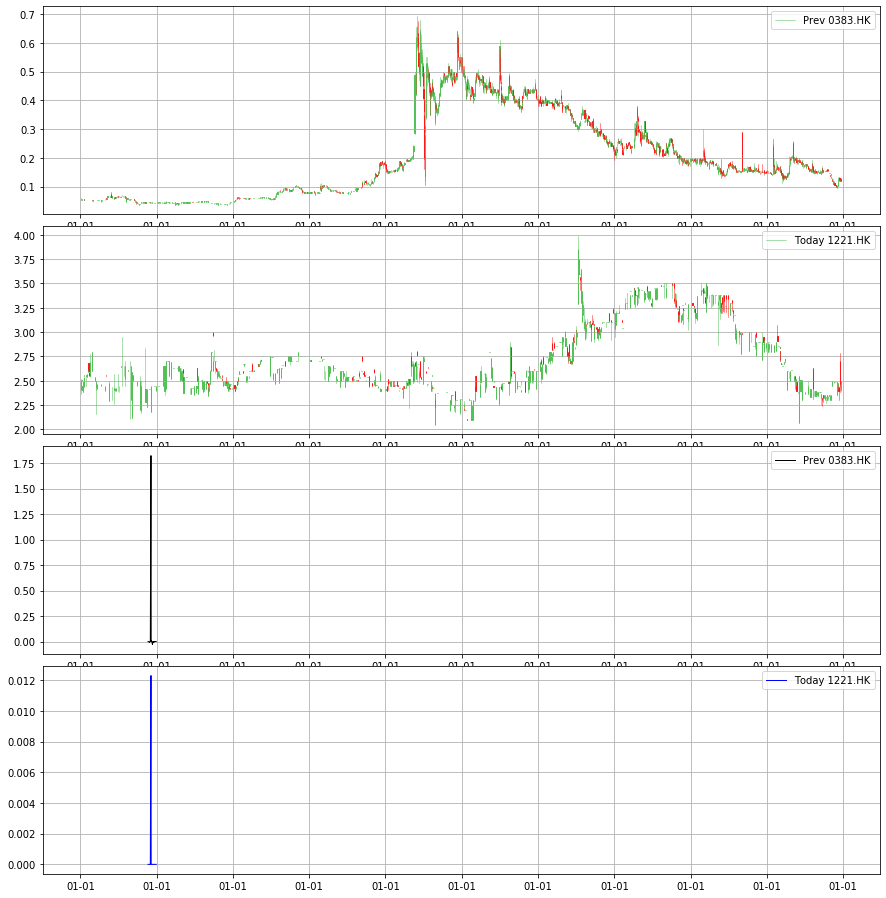

In [16]:
stock1 = '0383.HK.prev'
stock2 = '1221.HK'
#
tools.plot_two_stocks(stock1, stock2, prevday_returns, today_returns, train_start)

### Upload to AWS S3

In [17]:
s3_bucket = 'slack-trading'
local_path = '../data'
tools.upload_data_to_s3(s3_bucket, local_path)

### Verify Linear regression

    catstock = pair['prev']
    column = pair['today']
    X = prevday_returns[[catstock]].copy()
    X = sm.add_constant(X)
    y = today_returns[[column]]
    model = sm.OLS(y, X).fit()
    data = {
        'Prev' : catstock,
        'Today' : column,
        'Params' : model.params.iloc[1],
        'TValues' : abs(model.tvalues.iloc[1]),
        'RSquared' : model.rsquared
    }

In [ ]:
prevday_returns[stock1]

In [ ]:
today_returns[stock2]

In [ ]:
X = prevday_returns[stock1].copy()
X = sm.add_constant(X)
y = today_returns[stock2]
model = sm.OLS(y, X).fit()
print('Params {:.4f} TValues {:.4f} RSquared {:.4f}'.format(model.params.iloc[1], model.tvalues.iloc[1], model.rsquared))